In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

RDKit WARNING: [14:48:12] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# let's define the Tanimoto similarity for ourselves:

def tanimoto(vector1, vector2):
    set_bits = 0
    shared_bits = 0
    for bit1, bit2 in zip(vector1, vector2):
        if bit1 or bit2: # at least one vector has this feature
            set_bits += 1
            if bit1 and bit2: # both vectors have this feature
                shared_bits += 1
    return shared_bits / set_bits

# and check our implementation on several vectors
print(tanimoto([1, 1, 0, 0], [0, 0, 1, 1])) # share nothing
print(tanimoto([0, 1, 1, 0], [1, 0, 1, 0])) # share bit of 3
print(tanimoto([1, 1, 1, 1], [0, 0, 1, 1])) # share 2 bits of 4
print(tanimoto([1, 1, 1, 1], [0, 1, 1, 1])) # share 3 bits of 4
print(tanimoto([1, 1, 0, 0], [1, 1, 0, 0])) # share 2 bits of 2

0.0
0.3333333333333333
0.5
0.75
1.0


In [3]:
# load your own set, and DrugBank :)
with open('../bojicm/compound/chembl395.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    mtor_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

RDKit ERROR: [14:49:04] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [14:49:04] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [14:49:04] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [14:49:04] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [14:49:04] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [14:49:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [14:49:04] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [14:49:04] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [14:49:04] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [14:49:04] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [14:49:04] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [14:49:04] Can't kek

RDKit ERROR: [14:49:04] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [14:49:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [14:49:04] ERROR: Could not sanitize molecule ending on line 628065
RDKit ERROR: [14:49:04] ERROR: Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [14:49:04] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [14:49:04] ERROR: Could not sanitize molecule ending on line 636938
RDKit ERROR: [14:49:04] ERROR: Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [14:49:05] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [14:49:05] ERROR: Could not sanitize molecule ending on line 640674
RDKit ERROR: [14:49:05] ERROR: Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [14:49:05] Explicit valence for atom # 17 Mg, 4, is greater than permitte

In [4]:
from rdkit.Chem import MACCSkeys
fp1 = MACCSkeys.GenMACCSKeys(drugs[123])
fp2 = MACCSkeys.GenMACCSKeys(drugs[666])
print(fp1.ToBitString())
print(fp2.ToBitString())

00000000000000000000000000000000000000000000000000000100000000000000000000000000000010000100000001000000000000000100000000010001000101010001000110100011101011110111110
00000000000000000000000000000010000000000000000001000000010000000000000000100000000001100000010100101100010011011101101000110110000010000110010011111100111111111111110


In [5]:
tanimoto(fp1, fp2)

0.25

In [6]:
from rdkit import DataStructs

In [7]:
DataStructs.TanimotoSimilarity(fp1, fp2) # same result as our own implementation :)

0.25

In [8]:
mtor_ligands_maccs = [MACCSkeys.GenMACCSKeys(m) for m in mtor_ligands]
drugs_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugs]

In [13]:
def similarity_search(query_fp, searched_fp_set, cutoff=0.8):
    # we have no index, so we will have to just iterate through the entire searched set
    hits = []
    for i, fp in enumerate(searched_fp_set):
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        if similarity >= cutoff: # similar enough for consideration
            hits.append((i, similarity))
    return sorted(hits, key=lambda x: x[1], reverse=True) # stronger hits first

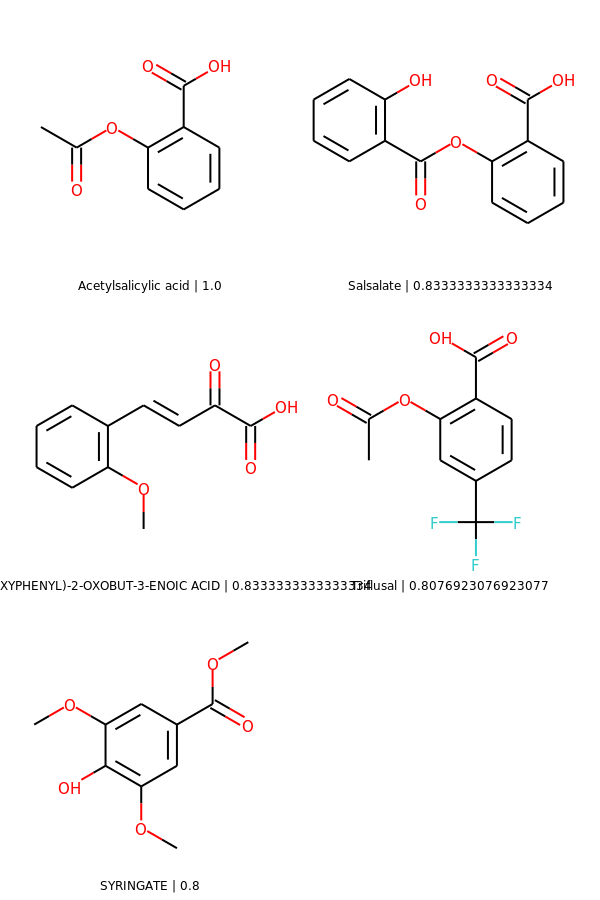

In [14]:
# let's use our similarity search method to search of aspirin in drugs.
# There should be some hits :)
aspirin = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
aspirin_fp = MACCSkeys.GenMACCSKeys(aspirin)
hits = similarity_search(aspirin_fp, drugs_maccs)
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=["{} | {}".format(drugs[hit[0]].GetProp('GENERIC_NAME'), hit[1]) for hit in hits])

In [15]:
hits = similarity_search(mtor_ligands_maccs[0], drugs_maccs)
hits

[]

In [16]:
hits

[]

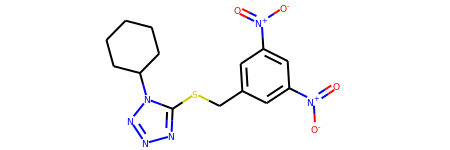

In [17]:
mtor_ligands[0]  # my query structure

In [18]:
# the hits among Drugbank using MACCS keys
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits], legends=["{} | {}".format(hit[0], hit[1]) for hit in hits])

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fde28e57d00>

In [19]:
mtor_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                     for m in mtor_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
              for m in drugs]

In [20]:
hits = similarity_search(mtor_ligands_ecfp[0], drugs_ecfp)
hits

[]

In [21]:
DataStructs.TanimotoSimilarity(mtor_ligands_ecfp[0], drugs_ecfp[6687])

0.042105263157894736

In [22]:
DataStructs.TanimotoSimilarity(mtor_ligands_ecfp[0], drugs_ecfp[5430])

0.05813953488372093

In [24]:
mtor_ligands_queries = [(i, similarity_search(ligand_ecfp, drugs_ecfp))
                     for i, ligand_ecfp in enumerate(mtor_ligands_ecfp)]
mtor_ligands_queries

[(0, []),
 (1, []),
 (2, []),
 (3, []),
 (4, []),
 (5, []),
 (6, []),
 (7, []),
 (8, []),
 (9, []),
 (10, []),
 (11, []),
 (12, []),
 (13, []),
 (14, []),
 (15, []),
 (16, []),
 (17, []),
 (18, []),
 (19, [(593, 1.0)]),
 (20, []),
 (21, []),
 (22, []),
 (23, []),
 (24, [(1123, 0.8947368421052632), (1104, 0.8631578947368421), (4669, 0.83)]),
 (25, []),
 (26, []),
 (27, []),
 (28, []),
 (29, []),
 (30, []),
 (31,
  [(332, 0.9857142857142858),
   (876, 0.9857142857142858),
   (579, 0.8648648648648649)]),
 (32, []),
 (33, []),
 (34, []),
 (35, []),
 (36, []),
 (37, []),
 (38, []),
 (39, []),
 (40, []),
 (41, []),
 (42, []),
 (43, []),
 (44, []),
 (45, []),
 (46, []),
 (47, []),
 (48, []),
 (49, [(930, 1.0)]),
 (50, []),
 (51, []),
 (52, []),
 (53, []),
 (54, []),
 (55, []),
 (56, []),
 (57, []),
 (58, []),
 (59, []),
 (60, []),
 (61, []),
 (62, []),
 (63, []),
 (64, []),
 (65, []),
 (66, []),
 (67, []),
 (68, []),
 (69, []),
 (70, []),
 (71, []),
 (72, []),
 (73, []),
 (74, []),
 (75, []),

For every ligand, we have a list of drugs that match their structural features (ECFP4, 1024bit) at Tanimoto similarity of 0.8 and higher.

In [25]:
# only take ligands that actually matched something in DrugBank
mtor_ligand_hits = [hit for hit in mtor_ligands_queries if hit[1]]
mtor_ligand_hits

[(19, [(593, 1.0)]),
 (24, [(1123, 0.8947368421052632), (1104, 0.8631578947368421), (4669, 0.83)]),
 (31,
  [(332, 0.9857142857142858),
   (876, 0.9857142857142858),
   (579, 0.8648648648648649)]),
 (49, [(930, 1.0)]),
 (86, [(429, 1.0)]),
 (87, [(332, 1.0), (876, 1.0), (579, 0.8767123287671232)]),
 (99, [(4167, 1.0)]),
 (101, [(123, 1.0)]),
 (104, [(1210, 1.0)]),
 (124, [(415, 1.0)]),
 (134, [(332, 1.0), (876, 1.0), (579, 0.8767123287671232)]),
 (149, [(429, 1.0)]),
 (160, [(271, 1.0)]),
 (181, [(1754, 1.0)]),
 (202, [(4167, 0.8275862068965517)]),
 (209, [(332, 1.0), (876, 1.0), (579, 0.8767123287671232)]),
 (212, [(657, 1.0)]),
 (215, [(657, 1.0)]),
 (231, [(657, 1.0)]),
 (285, [(643, 1.0)]),
 (287, [(657, 1.0)]),
 (288, [(415, 1.0)]),
 (299, [(7018, 0.8181818181818182)]),
 (302, [(504, 1.0), (4212, 0.8115942028985508)]),
 (315, [(332, 1.0), (876, 1.0), (579, 0.8767123287671232)]),
 (324, [(117, 1.0)]),
 (346, [(332, 1.0), (876, 1.0), (579, 0.8767123287671232)]),
 (347, [(332, 1.0), 

In [26]:
len(mtor_ligands_queries), len(mtor_ligand_hits)

(20127, 1214)

In [27]:
mtor_ligand_hits[1]

(24, [(1123, 0.8947368421052632), (1104, 0.8631578947368421), (4669, 0.83)])

In the above, the HepG2 ligand 24 hits DrugBank structure 1123 fully by Tanimoto similarity over ECFP4 fingerprints, and also hits structures 1104 and 4669 on a high degree of similarity.

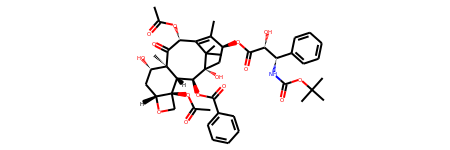

In [28]:
# The query structure
mtor_ligands[mtor_ligand_hits[1][0]]

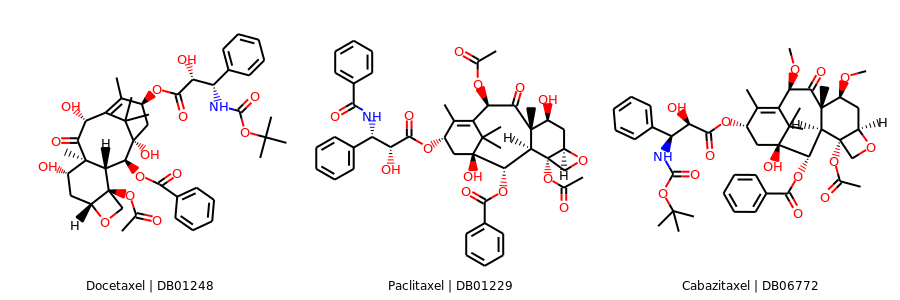

In [29]:
# And the DrugBank hits to that
hit_mols = [drugs[index] for index, similarity in mtor_ligand_hits[1][1]]
Draw.MolsToGridImage(hit_mols, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols])

In [30]:
drugs_hitcounts = {}
for ligand, hits in mtor_ligand_hits:
    for hit, similarity in hits:
        drugs_hitcounts[hit] = drugs_hitcounts.get(hit, 0) + 1
drugs_hitcounts

{593: 7,
 1123: 5,
 1104: 75,
 4669: 1,
 332: 267,
 876: 267,
 579: 268,
 930: 3,
 429: 136,
 4167: 40,
 123: 6,
 1210: 26,
 415: 18,
 271: 8,
 1754: 3,
 657: 50,
 643: 1,
 7018: 20,
 504: 5,
 4212: 5,
 117: 4,
 6267: 4,
 4405: 8,
 6701: 36,
 849: 2,
 4693: 1,
 993: 3,
 212: 3,
 4448: 1,
 6583: 1,
 1140: 10,
 5853: 10,
 286: 31,
 6675: 31,
 6148: 3,
 455: 24,
 426: 23,
 199: 13,
 1615: 2,
 5766: 7,
 493: 16,
 1396: 16,
 4835: 1,
 328: 4,
 144: 3,
 1898: 1,
 903: 1,
 6976: 9,
 1055: 15,
 448: 3,
 908: 7,
 566: 4,
 5358: 6,
 1121: 1,
 732: 1,
 320: 1,
 3047: 7,
 181: 4,
 1132: 3,
 98: 4,
 90: 4,
 508: 2,
 714: 2,
 797: 4,
 207: 15,
 96: 4,
 6785: 2,
 746: 4,
 2239: 22,
 823: 12,
 70: 1,
 4493: 1,
 831: 10,
 382: 5,
 331: 1,
 2836: 1,
 486: 4,
 3658: 6,
 87: 3,
 369: 4,
 4325: 2,
 972: 2,
 1080: 2,
 3478: 1,
 2953: 17,
 3680: 17,
 5770: 17,
 5771: 17,
 2377: 17,
 2370: 17,
 2899: 17,
 42: 1,
 252: 1,
 3747: 5,
 2390: 5,
 228: 2,
 3683: 2,
 5224: 3,
 920: 1,
 4975: 1,
 4920: 1,
 964: 2,
 1

In [31]:
ordered_drugs_hitcounts = sorted(drugs_hitcounts.keys(), key=lambda x: drugs_hitcounts[x], reverse=True)
ordered_drugs_hitcounts

[579,
 332,
 876,
 429,
 1104,
 657,
 4167,
 6701,
 286,
 6675,
 1210,
 455,
 426,
 2239,
 7018,
 415,
 2953,
 3680,
 5770,
 5771,
 2377,
 2370,
 2899,
 493,
 1396,
 1055,
 207,
 199,
 823,
 1140,
 5853,
 831,
 6976,
 271,
 4405,
 593,
 5766,
 908,
 3047,
 195,
 123,
 5358,
 3658,
 5571,
 866,
 1832,
 4497,
 1123,
 504,
 4212,
 382,
 3747,
 2390,
 326,
 117,
 6267,
 328,
 566,
 181,
 98,
 90,
 797,
 96,
 746,
 486,
 369,
 422,
 4494,
 79,
 1053,
 3003,
 930,
 1754,
 993,
 212,
 6148,
 144,
 448,
 1132,
 87,
 5224,
 560,
 3969,
 247,
 416,
 4145,
 6292,
 849,
 1615,
 508,
 714,
 6785,
 4325,
 972,
 1080,
 228,
 3683,
 964,
 1485,
 66,
 3351,
 622,
 3372,
 646,
 3713,
 4181,
 6799,
 3824,
 4658,
 1830,
 1850,
 357,
 85,
 525,
 3121,
 5619,
 1212,
 396,
 511,
 250,
 522,
 28,
 4454,
 1247,
 6666,
 4873,
 6678,
 4669,
 643,
 4693,
 4448,
 6583,
 4835,
 1898,
 903,
 1121,
 732,
 320,
 70,
 4493,
 331,
 2836,
 3478,
 42,
 252,
 920,
 4975,
 4920,
 6520,
 6656,
 853,
 2730,
 526,
 4641,
 660,

/home/milan/miniconda3/envs/cdd/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


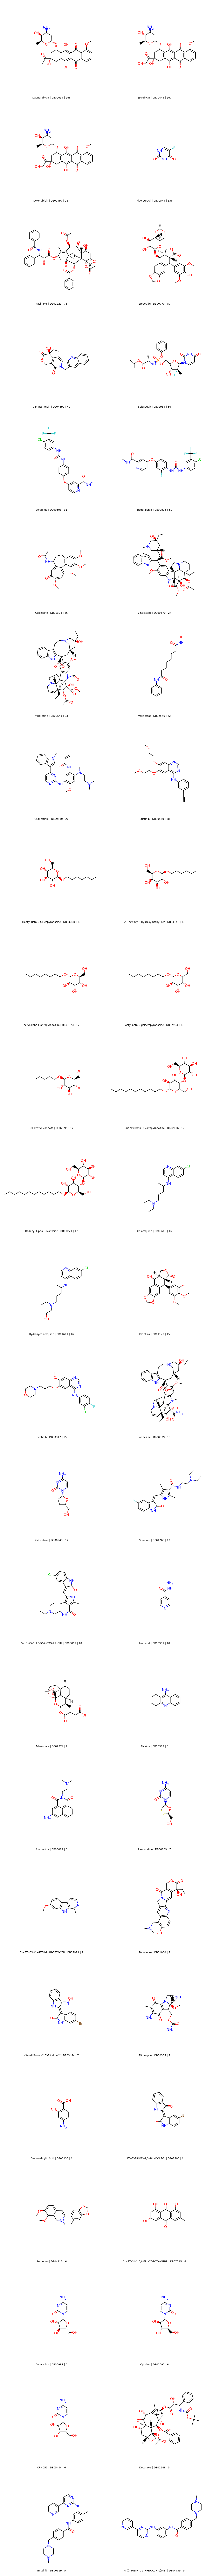

In [32]:
hit_mols = [drugs[i] for i in ordered_drugs_hitcounts]
Draw.MolsToGridImage(hit_mols, molsPerRow=2, subImgSize=(500,500),
                     legends=["{} | {} | {}".format(drugs[i].GetProp('GENERIC_NAME')[:30], # just cut off too long IUPAC stuff
                                                    drugs[i].GetProp('DRUGBANK_ID'),
                                                    drugs_hitcounts[i])
                              for i in ordered_drugs_hitcounts])

In [33]:
def distance_function(index1, index2, *args, fingerprints=mtor_ligands_ecfp,
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [34]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(mtor_ligands), 45))
picked

[18602,
 7198,
 17126,
 4464,
 3232,
 16140,
 17833,
 7953,
 6870,
 7322,
 13929,
 19263,
 72,
 15825,
 5404,
 10583,
 14411,
 2651,
 18452,
 13518,
 2227,
 19061,
 7116,
 8112,
 3189,
 1207,
 2338,
 18829,
 7222,
 3912,
 20035,
 12073,
 3662,
 7705,
 13860,
 17423,
 1121,
 15771,
 1133,
 11100,
 309,
 4852,
 9523,
 9815,
 17231]

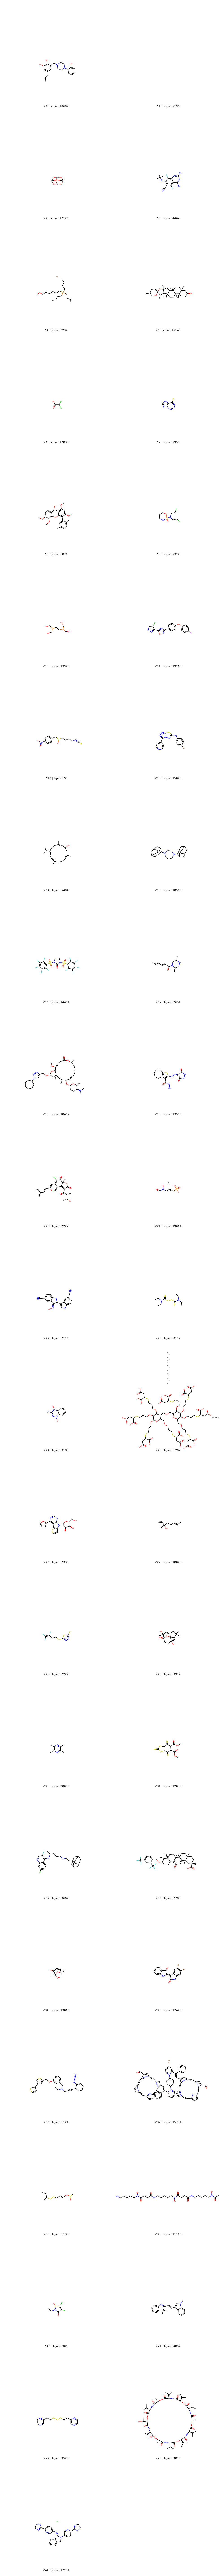

In [35]:
Draw.MolsToGridImage([mtor_ligands[i] for i in picked], molsPerRow=2, subImgSize=(500,500),
                     legends=["#{} | ligand {}".format(i, hit) for i, hit in enumerate(picked)])